# Mounting drive and unzipping dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip gdrive/My\ Drive/dataset.zip > /dev/null

# Data loading and reshaping

In [28]:
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder
from torchvision import models
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_uppercase
import time
import copy
from google.colab import files

In [6]:
train_set_prev = ImageFolder(root='data/train', transform=T.Compose([T.Resize((200,200)), T.ToTensor()]))
train_loader_prev = DataLoader(train_set_prev)
test_set_prev = ImageFolder(root='data/test', transform=T.Compose([T.Resize((200,200)), T.ToTensor()]))
test_loader_prev = DataLoader(test_set_prev)

In [7]:
# coping a structure of folders for changed images
!rsync -a --include '*/' --exclude '*' "data/test" "data_proc"
!rsync -a --include '*/' --exclude '*' "data/train" "data_proc"

In [8]:
# resizing both datasets
num_classes = len(ascii_uppercase)
classes_dict = dict(zip(range(num_classes), ascii_uppercase))
for index,(data,target) in enumerate(test_loader_prev):
    save_image(data, f'data_proc/test/{classes_dict[target.item()]}/{index}.jpg')
for index,(data,target) in enumerate(train_loader_prev):
    save_image(data, f'data_proc/train/{classes_dict[target.item()]}/{index}.jpg')

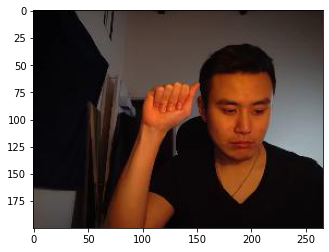

In [9]:
# example of image before and after resizing
image = plt.imread('data/train/A/A_00003.jpg')
plt.imshow(image)

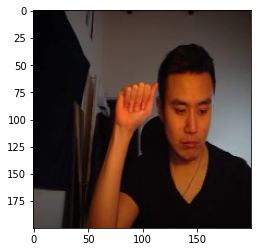

In [10]:
train_ex_image = train_set_prev[2]
plt.imshow(train_ex_image[0].permute(1,2,0))

In [11]:
batch_size = 64
test_batch_size = 1
seed = 1

In [12]:
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_kwargs = {'batch_size':batch_size, 'shuffle':True, 'num_workers':1}
test_kwargs = {'batch_size':test_batch_size, 'shuffle':True, 'num_workers':1}

train_set = ImageFolder(root='data_proc/train', transform=T.Compose([T.Resize((200,200)), T.ToTensor()]))
test_set = ImageFolder(root='data_proc/test', transform=T.Compose([T.Resize((200,200)), T.ToTensor()]))
dataloaders = {'train':DataLoader(train_set, **train_kwargs), 'val':DataLoader(test_set, **test_kwargs)}
dataset_sizes = {'train':len(train_set), 'val':len(test_set)}
class_names = train_set.classes

# Training 
Big part taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

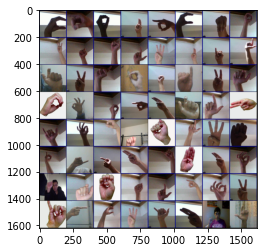

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = make_grid(inputs)
imshow(out)

In [31]:
#number of batches
print(dataset_sizes['train']/batch_size)

3208.703125


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                if batch_idx % 500 == 0: print(f'batch {batch_idx}')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [32]:
model_conv = models.resnet18(pretrained=True, progress=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, len(class_names))


model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=3*0.01)

# Decay LR by a factor of 0.1 every 8 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=8, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
batch 0
batch 500
batch 1000
batch 1500
batch 2000
batch 2500
batch 3000
train Loss: 1.8024 Acc: 0.8046
batch 0
batch 500
val Loss: 16.6508 Acc: 0.3189

Epoch 1/19
----------
batch 0
batch 500
batch 1000
batch 1500
batch 2000
batch 2500
batch 3000
train Loss: 1.8743 Acc: 0.8169
batch 0
batch 500
val Loss: 15.7939 Acc: 0.3462

Epoch 2/19
----------
batch 0
batch 500
batch 1000
batch 1500
batch 2000
batch 2500
batch 3000
train Loss: 1.8840 Acc: 0.8270
batch 0
batch 500
val Loss: 19.7930 Acc: 0.3151

Epoch 3/19
----------
batch 0
batch 500
batch 1000
batch 1500
batch 2000
batch 2500
batch 3000
train Loss: 1.9033 Acc: 0.8313
batch 0
batch 500
val Loss: 17.8790 Acc: 0.3387

Epoch 4/19
----------
batch 0
batch 500
batch 1000
batch 1500
batch 2000
batch 2500
batch 3000
train Loss: 1.9227 Acc: 0.8362
batch 0
batch 500
val Loss: 20.1834 Acc: 0.3263

Epoch 5/19
----------
batch 0
batch 500
batch 1000
batch 1500
batch 2000
batch 2500
batch 3000
train Loss: 1.9645 Acc: 0.8397

In [29]:
# saving and downloading model
torch.save(model_conv.state_dict(), 'model_weights_usign.pth')
files.download('model_weights_usign.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>